In [219]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

In [220]:
data = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31")

[*********************100%***********************]  6 of 6 completed


In [221]:
data.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2009-12-31  6.426001        NaN        NaN        NaN  15.441621        NaN   
2010-01-04  6.526021  24.106215  19.280519  32.229897  15.610239  39.131073   
2010-01-05  6.537303  23.740725  19.436934  32.749939  15.541497  38.881393   
2010-01-06  6.433319  23.891224  19.737720  32.407471  15.149715  38.807625   
2010-01-07  6.421427  23.732662  19.912174  32.553341  14.797037  38.643066   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2009-12-31  7.526071        NaN        NaN        NaN  ...        NaN   
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2009-12-31        NaN  15.560426        NaN  352410800.0        NaN   
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   

                                                          
               BMW.DE     DBK.DE         GOOG     RWE.DE  
Date                                                      
2009-12-31        NaN        NaN   48974884.0        NaN  
2010-01-04  1808170.0  4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0  5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0  5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0  4506202.0  257533695.0  1765257.0  

[5 rows x 36 columns]

In [222]:
data = data["Adj Close"]

In [223]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
Date,,,,,,
2009-12-31,6.426001,NaN,NaN,NaN,15.441621,NaN
2010-01-04,6.526021,24.106215,19.280519,32.229897,15.610239,39.131073
2010-01-05,6.537303,23.740725,19.436934,32.749939,15.541497,38.881393
2010-01-06,6.433319,23.891224,19.737720,32.407471,15.149715,38.807625
2010-01-07,6.421427,23.732662,19.912174,32.553341,14.797037,38.643066


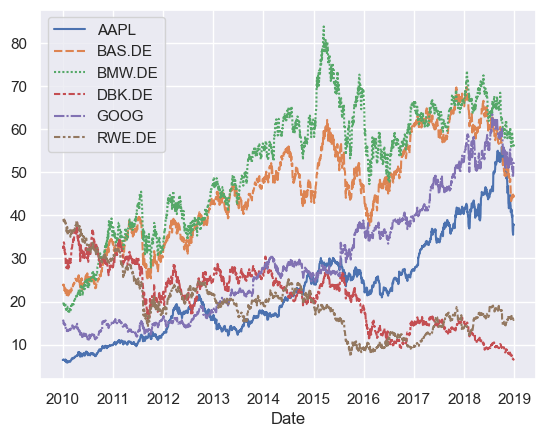

In [224]:
sns.lineplot(data = data);

In [225]:
data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns)

In [226]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,0.172742,-1.527776,0.807981,1.600661,-0.441336,-0.640104
1,-1.603424,0.631928,1.535650,-1.051212,-2.553194,-0.189908
2,-0.185019,-0.665894,0.879976,0.449103,-2.355478,-0.424938
3,0.662617,-0.306188,-1.353533,3.578309,1.324303,-0.146958
4,-0.886054,-1.119392,-1.496368,-1.210329,-0.151272,1.169614


In [227]:
data = data.dropna(axis=0)

In [228]:
#for i in range(0, data.shape[1]):
 #   data.iloc[:, i] = data.iloc[:, i][data.iloc[:, i].between(data.iloc[:, i].quantile(0.05), data.iloc[:, i].quantile(0.95))]

In [229]:
data = data.dropna(axis = 0)

In [230]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,0.172742,-1.527776,0.807981,1.600661,-0.441336,-0.640104
1,-1.603424,0.631928,1.535650,-1.051212,-2.553194,-0.189908
2,-0.185019,-0.665894,0.879976,0.449103,-2.355478,-0.424938
3,0.662617,-0.306188,-1.353533,3.578309,1.324303,-0.146958
4,-0.886054,-1.119392,-1.496368,-1.210329,-0.151272,1.169614


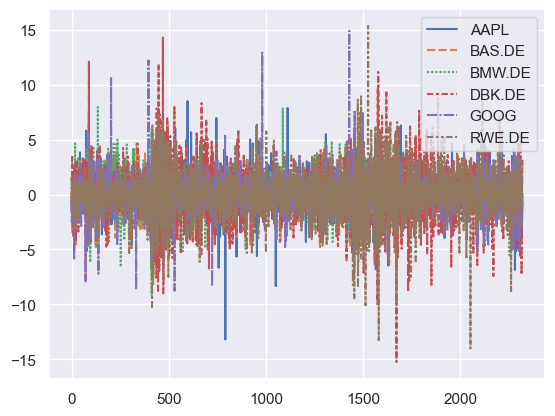

In [231]:
sns.lineplot(data = data);

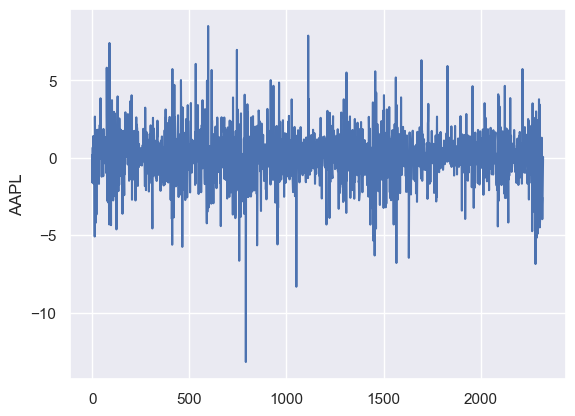

In [232]:
sns.lineplot(data = data.AAPL);

# Simulate random portfolio returns and volatility

In [233]:
m, n = data.shape # m = return periods, n = number of stocks

In [234]:
n_PFs = 500 # number of PFs to simulate

In [235]:
w = np.random.random([n_PFs,n]) # create random PF weights


In [236]:
for i in range(0, n_PFs): # scale so they add up to one
    w[i] = w[i] / w[i].sum()

In [237]:
PFReturns = np.empty(shape = (m, n_PFs))

In [238]:
# calculate simulated PF-Returns

for i in range(0, m):
    for j in range(0, n_PFs):
        PFReturns[i,j] = np.mean(w[j] * data.iloc[i])
        


In [239]:
# calculate means and stds

returns_mean = PFReturns.mean(axis=0)
returns_std = PFReturns.std(axis = 0)

In [240]:
results = pd.DataFrame([returns_mean, returns_std]).T


In [241]:
results.columns = ["mean", "std"]

In [242]:
results.head()

,mean,std
0,0.001045,0.219132
1,-0.006364,0.283433
2,0.001902,0.231859
3,0.001020,0.230378
4,0.002365,0.202948


In [243]:
results.shape

(500, 2)

<AxesSubplot:xlabel='std', ylabel='mean'>

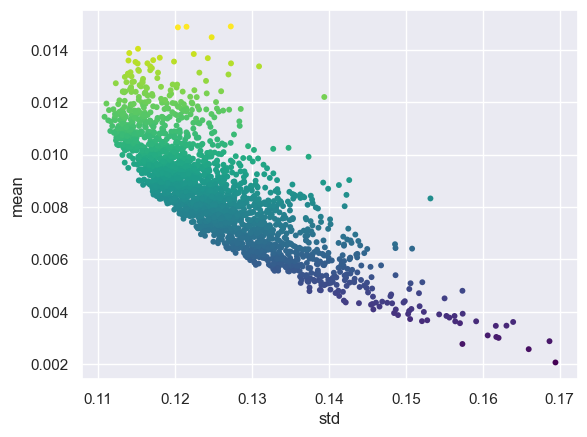

In [ ]:
# Plot simulated PF-Returns and stds

sns.scatterplot(y = results["mean"], x = results["std"], size=0.1, linewidth=0, palette="viridis", hue=results["mean"], legend=False)
plt.scatter(x=sigmamin, y = mumin, color="r")


# Efficient Frontier

In [252]:
mu = np.mean(data)
Cov = np.cov(data, rowvar=0)
C1 = np.linalg.inv(Cov)

In [253]:
a = mu.T.dot(C1).dot(mu)
b = np.ones([1,n]).dot(C1).dot(mu)
d = np.ones([1,n]).dot(C1).dot(np.ones([n,1]))

In [254]:
# calculate weights for minimum-variance PF

minvar = (1/d)*C1.dot(np.ones([n,1]))

In [255]:
minvar.shape

(6, 1)

In [256]:
minvar

array([[ 0.26619594],
       [ 0.26832796],
       [ 0.11976017],
       [-0.06353669],
       [ 0.28993852],
       [ 0.1193141 ]])

In [257]:
sigmamin = 1 / (np.sqrt(d))
mumin = b/d

In [258]:
sigmamin

array([[1.14727903]])

In [259]:
mumin

array([[0.03717946]])

In [272]:
minvar_returns = np.mean(minvar.flatten() * data, axis=1)

In [276]:
minvar_returns_mean = np.mean(minvar_returns)
minvar_returns_std = minvar_returns.std()

In [279]:
minvar_returns_std

0.19121317119250456

In [278]:
minvar_returns_mean

0.006196576632959403